# Sample use case: cross-sectional prediction of EDSS values.

The goal of this notebook is to get familiarized with the MEP database. We will go through the steps of selecting the appropriate data for a sample use case, as well as calculating some of the other values such as the approximate entropy and the peak-to-peak amplitude.<br>
<br>
As a working example we'll be using the task of predicting the EDSS-score of a patient, given the measurements made during a single visit. We'll be using a simple approach in which we only use the latency, the peak-to-peak amplitude (PPA), and the approximate entropy (which is a proxy for the morphological abnormality) of the motor evoked potential measurements. This is rather unlikely to produce amazing results (both because we're summarizing the measurement by 3 values, and because MEP measurements can't capture the full complexity of the EDSS since it only measures disability in the motor tracts), but it can serve as a baseline.

## Imports

In [1]:
%matplotlib notebook
import create_df_from_portable_dataset
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import scipy.signal
import scipy.spatial
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tqdm

# Kaggle - Stratified k-Fold cross-validation
import random
from collections import Counter, defaultdict

## Load the data

Try to load the cached version of the dataset. If not available, create it first from the zip archive.

In [2]:
cached_mep_path = './mep.p'
cached_edss_path = './edss.p'

if (os.path.isfile(cached_mep_path)) and (os.path.isfile(cached_edss_path)):
    df = pd.read_pickle(cached_mep_path)
    cdf = pd.read_pickle(cached_edss_path)
else:
    df, cdf = create_df_from_portable_dataset.single_dataframe('../data/mep_dataset.zip')
    df.to_pickle(cached_mep_path)
    cdf.to_pickle(cached_edss_path)

Linking timeseries


100%|██████████| 4013/4013 [00:32<00:00, 124.40it/s]


## Couple the EDSS values
The EDSS measurements are stored separately in the EDSS-dataframe. For each MEP measurement, we'll use the EDSS-value of the closest EDSS-measurement with a maximum of 6 months between the MEP- and EDSS-measurement.

In [3]:
tol = pd.Timedelta(days=365 // 2) # Roughly half a year

# Get the EDSS value for the EPTS measurements
new_groups = []
for name, group in df[df.has_edss_measurements].groupby('patient_uid', as_index=False):
    clin = cdf[cdf.patient_uid == name]
    new_groups.append(pd.merge_asof(
                          left=group.sort_values(by='visit_date'),
                          right=clin.sort_values(by='date').drop('patient_uid', axis=1),
                          left_on='visit_date',
                          right_on='date',
                          tolerance=tol,
                          direction='nearest',
                         )
                      )
ndf = pd.concat(new_groups).reset_index()

In [4]:
# Keep only the entries with a valid EDSS-measurement
ndf = ndf[pd.notnull(ndf['edss'])]
# Keep only the entries with a valid latency
ndf = ndf[pd.notnull(ndf['marker_1_latency(ms)'])]

In [5]:
# Sanity checks

# The EDSS-value should be the same for all measurements in a visit.
assert len(ndf.groupby(['patient_uid', 'visit_uid']).filter(lambda k: k.edss.nunique() != 1)) == 0
# The date of the EDSS measurement should not be further from the MEP measurement than the tolerance allows.
assert max(ndf.apply(lambda k: abs(k.visit_date - k.date), axis=1)) <= tol

## Machine and team selection
In the hospital there are two machines on which the measurements are performed. In the database, these are referred to as A and B. There are slight differences between the measurments of both, most notably the filter settings differ.

Furthermore, there are two separate teams that perform the measurements, indicated by team A and team B.

One will have to choose how to deal with this in one's model. In our case, we'll start out with the entire dataset.

In [6]:
# ndf = ndf[(ndf.team == 'A') & (ndf.machine == 'B')]

## Filter visits without all 4 tests present
We will discard visits that do not have all four tests.<br>
That is: APB (hands) left and right, and AH (feet) left and right.<br>
This is mainly done as the 'side' variable is based on the protocol of the nurses to do the measurements in order of right first, then left.<br>
When there's more than 4 measurements one cannot be sure of which side the extra measurement is.

In [7]:
# Convenience function to iterate over patients, visits, tests, or measurements
def iterate_over(df, kw):
    VALID = ['patient', 'visit', 'test', 'measurement']

    assert kw in VALID, '%s is not a valid keyword. Should be one of: %s' % (kw, ', '.join(VALID))

    index = VALID.index(kw)

    return df.groupby(['%s_uid' % s for s in VALID[:index+1]], as_index=False)

In [8]:
# Take only visits with each test accounted for
ndf = iterate_over(ndf, 'visit').filter(lambda v:
                                        # Four tests in the visit
                                        (v.test_uid.nunique() == 4)
                                        and
                                        # unique for anatomy and side
                                        (not iterate_over(v, 'test').nth(0)[['anatomy', 'side']].duplicated(keep=False).any())
                                       )

## Sample plot visit

In [9]:
# Some code to visualize the measurements of a single visit
def plot_mep_visit(visit_df):
    '''Plot the TS for a given visitid

    Parameters:
    df (pandas dataframe): Dataframe for visit
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    # The plot will contain 4 panes: APB - R, APB - L, AH - R, AH - L
    q = 0
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))
    for an in ['APB', 'AH']:
        for si in ['R', 'L']:
            loc_df = visit_df.query('anatomy == "%s" and side == "%s"' % (an, si))
            tp = (int(q / 2), int(q % 2))
            ld = loc_df['timeseries'].tolist()
            dur = 100.
            colors = plt.cm.summer
            for k in range(len(ld)):
                dt = float(100.) / ld[k].shape[0]
                x_range = [(x * dt) for x in range(ld[k].shape[0])]
                axs[tp].plot(x_range, ld[k], color=colors(float(k) / len(ld)))
            if len(ld) == 0:
                axs[tp].annotate('No data', xycoords='axes fraction', xy=(0.5, 0.5), ha='center', va='center')
            axs[tp].set_title('-'.join([an, si]))

            axs[tp].set_ylim(-0.8, 1.2)
            axs[tp].set_xlim(0., 100.)

            # Either allow flexible scaling
            # start, end = axs[tp].get_xlim()
            # or set values manually
            start, end = (0., 100.)
            axs[tp].xaxis.set_ticks(np.arange(start, end + 10., 10.))
            # start, end = axs[tp].get_ylim()
            start, end = (-0.8, 1.2)
            axs[tp].yaxis.set_ticks(np.arange(start, end + 0.2, 0.2))

            axs[tp].set_xlabel('Time (ms)')
            axs[tp].set_ylabel('Amplitude (mV)')
            axs[tp].set_axisbelow(True)
            axs[tp].xaxis.grid(color='gray', linestyle='dashed')
            axs[tp].yaxis.grid(color='gray', linestyle='dashed')

            axs[tp].set_aspect(10. / 0.2)
            q += 1
    plt.tight_layout()

<IPython.core.display.Javascript object>


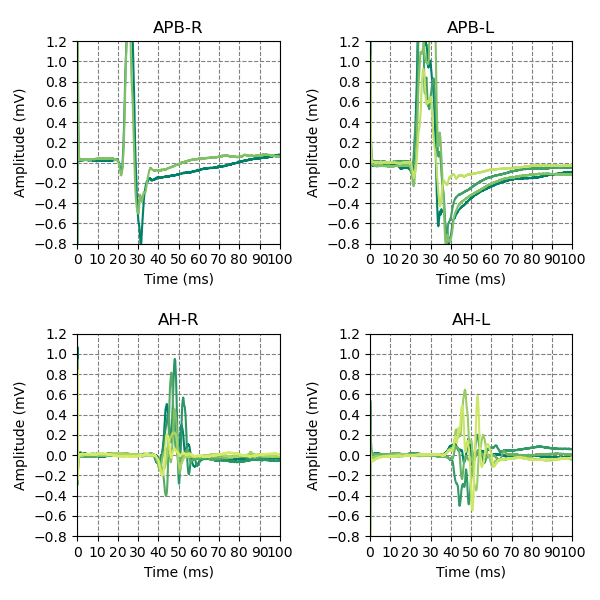

In [10]:
visits = [group for _, group in iterate_over(ndf, 'visit')]
# Random one
np.random.seed(123)
random_index = np.random.randint(len(visits))
plot_mep_visit(visits[random_index])

The whole thing is a **visit**<br>
Each subplot is a **test** (with a given anatomy and side)<br>
Each plot in the subplot is a **measurement**<br>
<br>
This is the way these plots are usually shown to the neurologists.

## Keeping only the measurements with maximum peak-to-peak amplitude (PPA)
Per test (e.g. left arm) there are multiple measurements. The general guidelines for MEP evaluation dictate that the measurement with the highest value of PPA is the most useful. The neurologists usually look at all measurements at once, however, so there may be more information from looking at them all. For our current use case, we'll keep only the maximum PPA measurements.

To do so, we'll have to calculate the PPA for the time series. There are two possible approaches:
* As the PPA is basically just the difference between markers 2 and 4, this value can be readily computed
* Calculate the PPA from the time series directly

The drawback of the first approach is missing values. To illustrate:

In [11]:
'Missing values: %.2f%%' % (ndf['marker_4_amplitude(mv)'].isnull().value_counts(normalize=True).loc[True] * 100)

'Missing values: 6.92%'

The drawback of the second approach is the occurence of measurement artifacts.

We'll use the second approach as measurement artifacts larger than the physiological peak will likely be a bad measurement anyways. For now we will not deal with such edge cases. We will, however, make sure to avoid the initial measurement artifact, present in nearly all MEP measurements. This artifact occurs due to the fact that the electrodes pick up the electrical field generated by the coil directly. This peak is uninformative, however. Since it tends to be rather large, it is important to disregard the first part of the time series when calculating the PPA.

We'll define a couple of functions to do this:

In [12]:
def get_maximal_peak_to_peak(df):
    '''Returns df containing only the repeated measurements with the maximum peak-to-peak per test
    
    df: Pandas dataframe
    '''
    _df = df.loc[[max(group.iterrows(), key=lambda k: peak_to_peak(k[1].timeseries))[0] for _, group in iterate_over(df, 'test')]]
    
    # Make sure the resulting df has one line per test, which can not be the case when the index is not unique
    assert iterate_over(df, 'test').ngroups == len(_df)
    return _df

def peak_to_peak(ts, offset=100):
    '''Maximum peak-to-peak value for a row
    
    Parameters
    ts: timeseries (numpy array)
    offset: determines how many points to discard at the start of the measurement
    '''
    return np.max(ts[offset:]) - np.min(ts[offset:])


In [13]:
ndf = get_maximal_peak_to_peak(ndf)

## Calculate the literature values
The values which are usually used to describe the MEPs are:
* The latency (which is directly available)
* The peak-to-peak amplitude (to be calculated)
* The morphological abnormality (to be calculated)

We will compute these next.

### Latency
Not much to do here, as this is just the first marker. We just have to make sure the value is available for the timeseries we're considering

In [14]:
# We already removed measurements without a valid latency
# Rename for convenience
ndf['lat'] = ndf['marker_1_latency(ms)']

### Peak-to-peak amplitude
We already discussed how to calculate these. We'll again use the second approach, i.e., calculate the PPA directly from the timeseries. We already calculated this before, the results of which we could have cached. But for clarity, we'll calculate it here again.

In [15]:
# Add the peak-to-peak amplitude feature, calculated directly from the timeseries
ndf['ppa'] = ndf.timeseries.apply(peak_to_peak)

### Morphological abnormality (ApEn)
Finally, we'll calculate the morphological abnormality, which we'll quantify using the approximate entropy. For more details:<br><br>
_Yperman, Jan, et al. "Deciphering the morphology of motor evoked potentials." Frontiers in neuroinformatics 14 (2020): 28._

Before we do this, we'll resample the timeseries that do not have 1920 samples

In [16]:
# Resample timeseries
ndf.loc[ndf.timeseries.apply(len) != 1920, 'timeseries'] = ndf[ndf.timeseries.apply(len) != 1920]\
                                                            .timeseries\
                                                            .apply(
                                                                lambda ts: scipy.signal.resample(ts, 1920)
                                                            )

In [17]:
# https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize/40085052#40085052
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

def approximate_entropy_efficient(y, mnom, rth):
    '''More efficient implementation of the approximate entropy calculation
    using Scipy
    '''
    n = y.shape[-1] # Length of the TS
    r = rth * np.std(y, axis=-1, ddof=1)
    phi = np.zeros((2, 1))

    for k in range(1, 3):
        m = mnom + k - 1 # Pattern length
        x = strided_app(y, m, 1)
        dd = np.mean(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(x, 'chebyshev')) <= r, axis=-1)
        phi[k-1] = np.mean(np.log(dd))

    return phi[0] - phi[1]

def approximate_entropy(y, mnom, rth):
    """Calculate the approximate entropy of a 1D timeseries
    Code adapted from HCTSA package (https://github.com/benfulcher/hctsa)
    """
    n = y.shape[-1] # Length of the TS
    r = rth * np.std(y, axis=-1, ddof=1)
    phi = np.zeros((2, 1))

    ds = []
    drs = []
    for k in range(1, 3):
        m = mnom + k - 1 # Pattern length
        C = np.zeros((n - m + 1, 1))
        x = np.zeros((n - m + 1, m))

        # Form vector sequences x from the time series y
        for i in range(n - m + 1):
            x[i, :] = y[i:i + m]

        ax = np.ones((n - m + 1, m));
        for i in range(n - m + 1):
            for j in range(m):
                ax[:, j] = x[i,j]; 
            d = abs(x - ax)
            if m > 1:
                d = np.max(d, axis=-1) 
            dr = d <= r
            ds.append(d)
            drs.append(dr)
            C[i] = np.sum(dr) / (n - m + 1)
        phi[k - 1] = np.mean(np.log(C))

    return phi[0] - phi[1]

def normalize_apen(apen_val, nc): 
    '''Normalize the ApEn values by the values used in the paper
    '''
    apen_norm = - (apen_val - nc['median']) / (nc['iqr'] / 1.35)
    apen_norm = 1. / (1 + np.exp(apen_norm))
    apen_norm = (apen_norm - nc['min']) / (nc['max'] - nc['min'])
    return apen_norm

def normalized_approximate_entropy_eff(x, m=None, r=None):
    nc = {
        'median': 0.0660287973,
        'iqr': 0.0629248893,
        'min': 0.230205474,
        'max': 1.0,
        'm': 2,
        'r': 0.2,
        'cutoff': 70
        }
    if len(x) != 1920:
        x = scipy.signal.resample(x, 1920)
    # ts = scipy.stats.zscore(x[nc['cutoff']:])
    ts = x[nc['cutoff']:]
    if (m is None) and (r is None):
        apen = approximate_entropy_efficient(ts, nc['m'], nc['r'])
    else:
        apen = approximate_entropy_efficient(ts, m, r)
    norm_apen = normalize_apen(apen, nc)
    return norm_apen

def normalized_approximate_entropy(x, m=None, r=None):
    nc = {
        'median': 0.0660287973,
        'iqr': 0.0629248893,
        'min': 0.230205474,
        'max': 1.0,
        'm': 2,
        'r': 0.2,
        'cutoff': 70
        }
    if len(x) != 1920:
        x = scipy.signal.resample(x, 1920)
    # ts = scipy.stats.zscore(x[nc['cutoff']:])
    ts = x[nc['cutoff']:]
    if (m is None) and (r is None):
        apen = approximate_entropy(ts, nc['m'], nc['r'])
    else:
        apen = approximate_entropy(ts, m, r)
    norm_apen = normalize_apen(apen, nc)
    return norm_apen

In [18]:
# As this can take some time when using a single core, use cached ApEn calculations
# Alternatively, calculate from scratch.
if os.path.isfile('apen_cache.p'):
    # Contains the ApEn for the /complete/ dataset
    cache = pd.read_pickle('apen_cache.p')
    ndf = ndf.merge(right=cache, on=['%s_uid' % s for s in ['patient', 'visit', 'test', 'measurement']], how='inner')
else:
    # Calculate ApEn from scratch
    # Do this in parallel as it takes a while. This will take ~30 seconds, depending on your hardware.

    # In Windows the multiprocessing does not work very well, though there is a workaround:
    # https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
    # For now, do not run in parallel for Windows
    if not os.name == 'nt':
        with multiprocessing.Pool() as p:
            results = list(tqdm.tqdm_notebook(p.imap(normalized_approximate_entropy_eff, ndf.timeseries.values, chunksize=10), total=len(ndf)))
    else:
        results = list(tqdm.tqdm_notebook(map(normalized_approximate_entropy_eff, ndf.timeseries.values), total=len(ndf)))

    ndf['apen'] = np.array(results).ravel()

As a (admittedly small) test to see if the ApEn was correctly computed, plot a few sample time series:

<IPython.core.display.Javascript object>


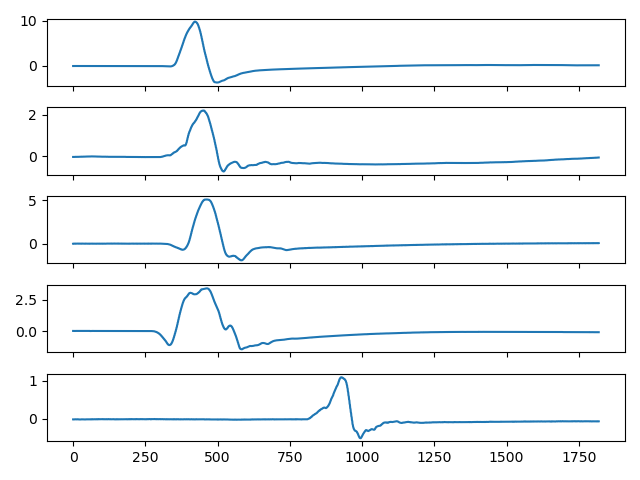

In [19]:
# Sanity check: Low approximate entropy should correspond with regular timeseries
n = 5
fig, ax = plt.subplots(n, 1, sharex=True)
for i, (_, row) in enumerate(ndf[ndf['apen'] < 0.2].sample(n).iterrows()):
    ax[i].plot(row.timeseries[100:])
plt.tight_layout()
plt.show()

## Facilitation

In some cases, it is very difficult to obtain a good measurement of a patient, no matter how strong the stimulus is. In these cases, the patient is sometimes asked to flex the muscle before the stimulus, which _facilitates_ the measurement. These measurements are characterized by a non-flat start of the measurement. Facilitated measurements can not be compared with regular measurements directly, and it is advised to simply discard them.

In [20]:
APB_min = 17                                                                                                                                                                                                                                                                          
AH_min = 35                                                                                                                                                                                                                                                                           
PEAK_min = 5

def signal_strength(ts):
    return np.sum(np.abs(ts))

def get_dt(row):
    return float(100.) / row['timeseries'].shape[0]

def sample_thres(dt, thresh):
    return int(thresh / dt)

def facilitated_indices(df):
    vals = []
    inds = []
    # First get the time per sample
    for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        tmp_dt = get_dt(row)
        st = signal_strength(row['timeseries'][sample_thres(tmp_dt, PEAK_min): sample_thres(tmp_dt, APB_min)])
        df.loc[index, 'fac'] = st

In [21]:
facilitated_indices(ndf)

100%|██████████| 15684/15684 [00:04<00:00, 3423.57it/s]


<IPython.core.display.Javascript object>


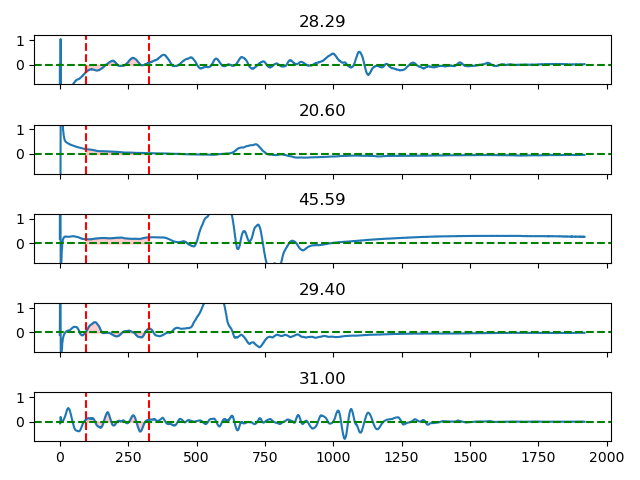

In [22]:
# Plot a few timeseries to illustrate the facilitated measurements
n = 5
fig, ax = plt.subplots(n, 1, sharex=True)
for i, (_, row) in enumerate(ndf[ndf['fac'] > 20].sample(n, random_state=1234).iterrows()):
    dt = get_dt(row)
    left_bound = sample_thres(dt, PEAK_min)
    right_bound = sample_thres(dt, APB_min)
    ax[i].fill_between(np.arange(len(row.timeseries))[left_bound:right_bound], np.zeros(len(row.timeseries))[left_bound:right_bound], row.timeseries[left_bound:right_bound], color=(1, 0, 0, 0.2))
    ax[i].plot(row.timeseries)
    ax[i].set_title('%.2f' % row['fac'])
    ax[i].set_ylim(-0.8, 1.2)
    ax[i].axvline(left_bound, ls='--', color='r')
    ax[i].axvline(right_bound, ls='--', color='r')
    ax[i].axhline(0, ls='--', color='g')
plt.tight_layout()
plt.show()

In [23]:
# Pretty arbitrary
ndf = ndf[ndf['fac'] < 20]

At this point we repeat the filtering of visits that have all 4 tests available. Why not perform the facilitation filter at the same point as the latency filtering? The rationale behind this is that when a facilitated measurement has the largest amplitude of all the measurements in a test, it is likely that the other measurements were not showing a strong enough signal, and will therefore likely not be suitable for our analysis.

In [24]:
# Repeat the filter of having all tests
ndf = iterate_over(ndf, 'visit').filter(lambda v:
                                        # Four tests in the visit
                                        (v.test_uid.nunique() == 4)
                                        and
                                        # unique for anatomy and side
                                        (not iterate_over(v, 'test').nth(0)[['anatomy', 'side']].duplicated(keep=False).any())
                                       )

## Age filter

In [25]:
INCLUDE_AGE = True
if INCLUDE_AGE:
    ndf = ndf[pd.notnull(ndf['date_of_birth'])]
    ndf['age'] = ndf.apply(lambda k: (k['visit_date'] - k['date_of_birth']).days, axis=1).values / 365.25

## Cross-validation
Now that we've calculated our features, we can proceed to the creation of the folds for the cross validation. Given the structure of the dataset, one has to take a few things into account.
* Patients should never occur in both the train- and the testset.
* The folds should have approximately the same distribution of the EDSS-values, i.e., they should be stratified.
* Ideally, stratification should also occur on the MS Type/sex/..., but given the size of the dataset, this may not be possible.

To achieve this, we'll use stratified, grouped K-fold cross-validation. This is not directly available in SKlearn, so we'll use an implementation from Kaggle:

In [26]:
# Kaggle - Stratified k-Fold cross-validation:
# Adapted from https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = np.array([i for i, g in enumerate(groups) if g in train_groups])
        test_indices = np.array([i for i, g in enumerate(groups) if g in test_groups])

        yield train_indices, test_indices

Due to low number of samples with 8.5 or higher, the stratification will struggle with these classes. We'll discard those samples from the dataset for now.

In [27]:
print(ndf.edss.value_counts().sort_index())
ndf = ndf[ndf.edss < 8.5]

0.0     600
1.0    1256
1.5    1612
2.0    2252
2.5    1548
3.0     988
3.5     904
4.0     856
4.5     412
5.0     212
5.5     188
6.0     684
6.5     680
7.0     144
7.5      68
8.0      36
8.5      12
Name: edss, dtype: int64


In [28]:
from sklearn.utils import resample as skres
# Create the X and y arrays
def create_X_y_groups(df, balance=False, groupby='patient'):
    if INCLUDE_AGE:
        FEATURES_V = ['age']
    else:
        FEATURES_V = []
    FEATURES_M = ['lat', 'ppa', 'apen']

    tdf = df.copy(deep=True)
    # tdf = ndf[(ndf.machine == 'A')].copy(deep=True)

    X = np.vstack(
        iterate_over(tdf, 'visit')\
        .apply(lambda k: np.hstack([k.sort_values(by=['anatomy', 'side'])[FEATURES_M].values.ravel(), k.iloc[0][FEATURES_V].ravel()])
    ).values)
    vdf = iterate_over(tdf, 'visit').nth(0).copy(deep=True)
    
    y = vdf.edss.values.ravel()
    # Create the groups. This is just an array with a unique identifier for each patient. You could also just use the
    # patient_uid field, but we'll use this notation to compare later with separating just visits.
    if groupby == 'patient':
        vdf['group'] = iterate_over(vdf, 'patient').ngroup()
    else:
        vdf['group'] = iterate_over(vdf, 'visit').ngroup()
    groups = vdf.group.values
    
    vdf.reset_index(inplace=True)
    
    print(X.shape)
    if balance:
        # Upsample minority classes
        rsdf_list = []
        n_samples = vdf.edss.value_counts().max()
        print(n_samples)
        for name, group in vdf.groupby('edss'):
            new_samples = skres(group, replace=True, n_samples=n_samples-len(group), random_state=123)
            rsdf_list.append(pd.concat([group, new_samples]))
        rsdf = pd.concat(rsdf_list)
        # concat keeps the old index
        rs_index = rsdf.index.values
        X = X[rs_index]
        y = y[rs_index]
        groups = groups[rs_index]
    
    return X, y, groups

### Unbalanced

#### Patients separated

In [29]:
X, y, groups = create_X_y_groups(ndf)

(3110, 13)


In [30]:
# To stratify we'll convert the float EDSS values to an identifier integer here
def to_categorical(x):
    mapper = {v: i for i, v in enumerate(np.sort(np.unique(x)))}
    return np.array(list(map(lambda k: mapper[k], x)))

In [31]:
from sklearn.svm import SVR

N_SPLITS = 5
# feature_labels = FEATURES_M * 4 + FEATURES_V

lr = LinearRegression(normalize=True)
dum = DummyRegressor(strategy='mean')
rf = RandomForestRegressor(max_depth=10, n_estimators=1000, n_jobs=-1)
sv = make_pipeline(StandardScaler(), SVR())
                           
all_res = {}
for clf in [rf, lr, dum, sv]:
    clf_name = clf.__class__.__name__
    # The split generator then becomes:
    split_gen = stratified_group_k_fold(X, to_categorical(y), groups, N_SPLITS, seed=1234)
    print(clf_name)
    res = pd.DataFrame(cross_validate(estimator=clf,
                         X=X,
                         y=y,
                         cv=split_gen,
                         scoring={
                            'MSE': make_scorer(mean_squared_error),
                            'MAE': make_scorer(mean_absolute_error),
                            # 'RMSE': make_scorer(lambda t, p: np.sqrt(mean_squared_error(t, p)))
                         },
                         return_train_score=True,
                         n_jobs=-1
                        )).agg(['mean', 'std'])
    all_res[clf_name] = res.T
    print(all_res[clf_name])
    print()


RandomForestRegressor
                mean       std
fit_time    2.278602  0.148284
score_time  0.166454  0.007786
test_MSE    1.988600  0.222539
train_MSE   0.520604  0.038873
test_MAE    1.074737  0.065652
train_MAE   0.550417  0.021697

LinearRegression
                mean       std
fit_time    0.002070  0.000165
score_time  0.000602  0.000018
test_MSE    1.846786  0.183797
train_MSE   1.772156  0.044948
test_MAE    1.040575  0.056915
train_MAE   1.016089  0.012387

DummyRegressor
                mean       std
fit_time    0.000517  0.000030
score_time  0.000402  0.000017
test_MSE    3.184740  0.067259
train_MSE   3.184982  0.016896
test_MAE    1.432983  0.010855
train_MAE   1.433027  0.003829

Pipeline
                mean       std
fit_time    0.475444  0.010332
score_time  0.096606  0.001233
test_MSE    1.923272  0.124546
train_MSE   1.320748  0.026873
test_MAE    1.041997  0.039259
train_MAE   0.791071  0.011442



In [32]:
def plot_results(results):
    # Only interested in the train and test scores
    results = results.loc[[i for i in results.index if any([x in i for x in ['train', 'test']])]]

    # ['MAE', 'MSE']
    measures = list(set([x.split('_')[-1] for x in results.index]))

    fig, axs = plt.subplots(ncols=len(measures), figsize=(8, 4), sharey=True)

    for (ax, meas) in zip(axs, measures):

        ax.set_title(meas)
        tdf = results.loc[[i for i in results.index if meas in i]]
        # Rename the labels
        tdf.rename({k: k.split('_')[0] for k in tdf.index}, axis=0, inplace=True)
        means = tdf[[k for k in tdf.keys() if 'mean' in k]]
        means.columns = means.columns.droplevel(1)
        stds = tdf[[k for k in tdf.keys() if 'std' in k]]
        stds.columns = stds.columns.droplevel(1)

        means.plot(kind='barh', xerr=stds, ax=ax, colormap='Dark2')
        ax.get_legend().remove()

        # Make room for the legend ..
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

        pw = ax.get_xlim()[1]

        # Print the scores
        for p in ax.patches:
            b = p.get_bbox()
            ax.annotate('%.2f' % (b.x1), (b.x0 + 0.02 * pw, (b.y0 + b.y1) / 2.), va='center', color='white')
            
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1))
    # fig.tight_layout()

<IPython.core.display.Javascript object>


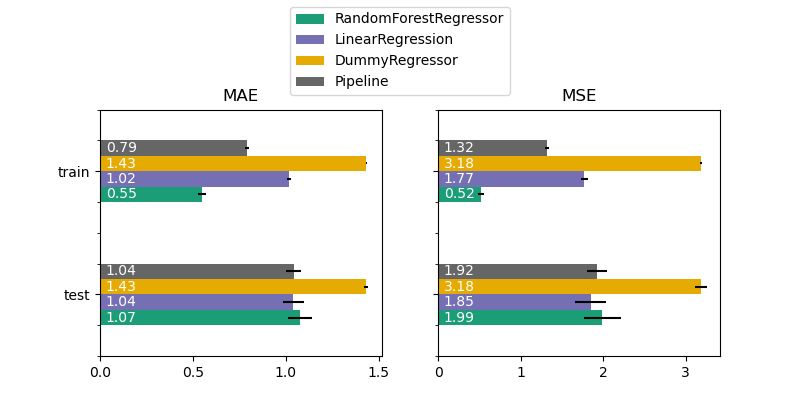

In [33]:
all_results = pd.concat(all_res, axis=1)
plot_results(all_results)

#### Patients not separated

It's important to not have patients which occur in both the training set and the test set.

In [34]:
X, y, groups = create_X_y_groups(ndf, groupby='visit')

(3110, 13)


In [35]:
from sklearn.svm import SVR

N_SPLITS = 5
# feature_labels = FEATURES_M * 4 + FEATURES_V

lr = LinearRegression(normalize=True)
dum = DummyRegressor(strategy='mean')
rf = RandomForestRegressor(max_depth=10, n_estimators=1000, n_jobs=-1)
sv = make_pipeline(StandardScaler(), SVR())
                           
all_res = {}
for clf in [rf, lr, dum, sv]:
    clf_name = clf.__class__.__name__
    # The split generator then becomes:
    split_gen = stratified_group_k_fold(X, to_categorical(y), groups, N_SPLITS, seed=1234)
    print(clf_name)
    res = pd.DataFrame(cross_validate(estimator=clf,
                         X=X,
                         y=y,
                         cv=split_gen,
                         scoring={
                            'MSE': make_scorer(mean_squared_error),
                            'MAE': make_scorer(mean_absolute_error),
                            # 'RMSE': make_scorer(lambda t, p: np.sqrt(mean_squared_error(t, p)))
                         },
                         return_train_score=True,
                         n_jobs=-1
                        )).agg(['mean', 'std'])
    all_res[clf_name] = res.T
    print(all_res[clf_name])
    print()


RandomForestRegressor
                mean       std
fit_time    2.288990  0.174341
score_time  0.164244  0.023509
test_MSE    1.442360  0.101693
train_MSE   0.535251  0.012043
test_MAE    0.904543  0.022258
train_MAE   0.561490  0.007953

LinearRegression
                mean       std
fit_time    0.002254  0.000290
score_time  0.000613  0.000019
test_MSE    1.796444  0.112208
train_MSE   1.777532  0.027836
test_MAE    1.023010  0.029717
train_MAE   1.017749  0.008628

DummyRegressor
                mean       std
fit_time    0.000522  0.000035
score_time  0.000405  0.000016
test_MSE    3.184900  0.030776
train_MSE   3.185014  0.007696
test_MAE    1.433015  0.005128
train_MAE   1.433035  0.001954

Pipeline
                mean       std
fit_time    0.489945  0.007535
score_time  0.118330  0.011843
test_MSE    1.604494  0.144457
train_MSE   1.351585  0.031836
test_MAE    0.925024  0.036943
train_MAE   0.805643  0.010091



<IPython.core.display.Javascript object>


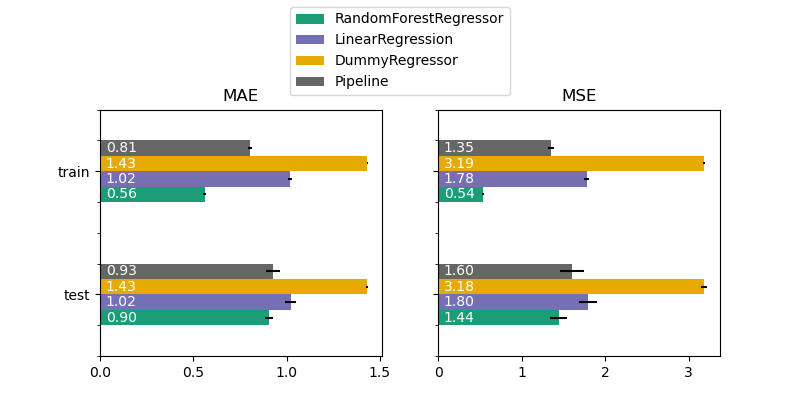

In [36]:
all_results = pd.concat(all_res, axis=1)
plot_results(all_results)

THESE ARE NOT VALID RESULTS DUE TO PATIENTS NOT BEING SEPARATED!

### Balanced

There is considerably imbalance between the various values of EDSS. We'll upsample the minority classes to see how the performance changes.

In [37]:
X, y, groups = create_X_y_groups(ndf, balance=True)

(3110, 13)
563


In [38]:
N_SPLITS = 10
# feature_labels = FEATURES_M * 4 + FEATURES_V

lr = LinearRegression(normalize=True)
dum = DummyRegressor(strategy='mean')
rf = RandomForestRegressor(max_depth=10, n_estimators=1000, n_jobs=-1)

all_res = {}
for clf in [rf, lr, dum]:
    clf_name = clf.__class__.__name__
    # The split generator then becomes:
    split_gen = stratified_group_k_fold(X, to_categorical(y), groups, N_SPLITS, seed=1234)
    print(clf_name)
    res = pd.DataFrame(cross_validate(estimator=clf,
                         X=X,
                         y=y,
                         cv=split_gen,
                         scoring={
                            'MSE': make_scorer(mean_squared_error),
                            'MAE': make_scorer(mean_absolute_error),
                            # 'RMSE': make_scorer(lambda t, p: np.sqrt(mean_squared_error(t, p)))
                         },
                         return_train_score=True,
                         n_jobs=-1
                        )).agg(['mean', 'std'])
    all_res[clf_name] = res.T
    print(all_res[clf_name])
    print()

RandomForestRegressor
                mean       std
fit_time    9.628628  0.573298
score_time  0.313418  0.143096
test_MSE    2.878335  0.737902
train_MSE   0.323515  0.021126
test_MAE    1.357324  0.179936
train_MAE   0.382860  0.015437

LinearRegression
                mean       std
fit_time    0.004612  0.000328
score_time  0.000639  0.000026
test_MSE    2.554387  0.778435
train_MSE   2.306936  0.082183
test_MAE    1.253346  0.170736
train_MAE   1.187203  0.022067

DummyRegressor
                mean       std
fit_time    0.000837  0.000060
score_time  0.000385  0.000021
test_MSE    5.484306  0.927576
train_MSE   5.556423  0.110350
test_MAE    2.010573  0.197143
train_MAE   2.029857  0.023996



<IPython.core.display.Javascript object>


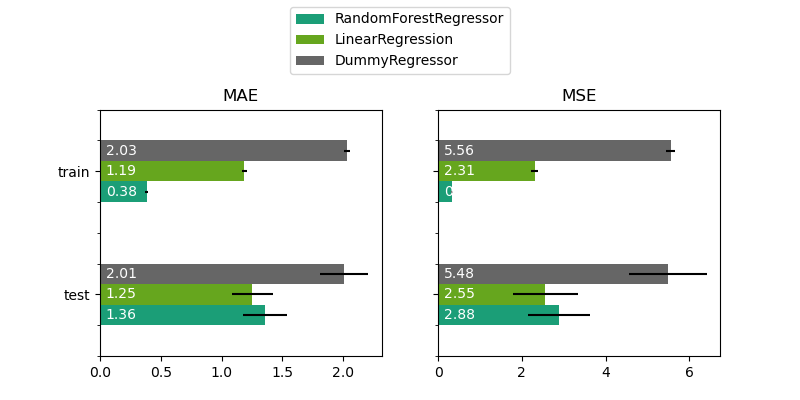

In [39]:
all_results = pd.concat(all_res, axis=1)
plot_results(all_results)

# Conclusion

We obtain a reasonable score for the cross-sectional prediction task, which could be further improved by adding more features, or performing hyperparameter optimization. We demonstrated the importance of keeping patients separate in train- and test splits. And finally, we showed that depending on the problem formulation, it may be important to upsample minority classes. In this case, sample with high EDSS values.